# [CoE202] note 08. Convolutional Neural Network MNIST classification (Pytorch)

- Class Date : 21.05.13.
- Office Hour : -----------
- If you have any questions, ask via KLMS Q&A board or come to TA office hour to get our help.

In [ ]:
# this is just an annotation
import numpy as np # this is for importing numpy library (and we will use abbreviation np for that)
import matplotlib.pyplot as plt # this is for importing matplotlib.pyplot (library for graph plot)
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [ ]:
# Set hyperparameters and settings
batch_size = 512
n_iter = 50
learning_rate = 0.001
seed = 1

torch.manual_seed(seed) # by setting this, things will become reproducible (nothing is  random)

useGPU = torch.cuda.is_available()
print(useGPU)
device = torch.device("cuda" if useGPU else "cpu")

True


## 1. Load dataset (MNIST) and split into train, valid and test set

In [ ]:
# load MNIST data
train_dataset = torchvision.datasets.MNIST("../mnist_data/",
                                               download=True,
                                               train=True,
                                               transform=transforms.Compose([
                                                    transforms.ToTensor(),
                                               ]))

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

test_dataset = torchvision.datasets.MNIST("../mnist_data/",
                                              download=True,
                                              train=False,
                                              transform=transforms.Compose([
                                                    transforms.ToTensor(),
                                              ]))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [ ]:
[one_batch_data, one_batch_label] = next(iter(train_loader))
print(one_batch_data.size(), one_batch_label.size())

torch.Size([512, 1, 28, 28]) torch.Size([512])


## 2. Visualization

In [ ]:
# define a function to plot data
def show_data(data, label):
    # data shape : torch.Size([Batch_size, 1, 28, 28])
    # label shape : torch.Size([4])
    num_row = 2
    num_col = 4
    fig, axes = plt.subplots(num_row, num_col)
    for i in range(8):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(data[i, 0].cpu(), cmap='gray')
        ax.set_title(f'label : {label[i].cpu().item()}')
    plt.tight_layout()
    plt.show()

ground truth example


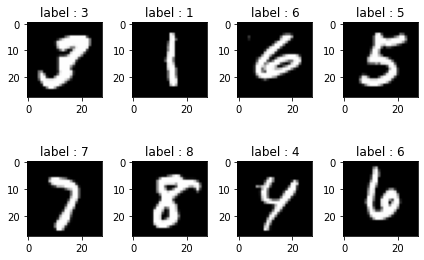

In [ ]:
# show ground truth classification (one batch)
print('ground truth example')
show_data(one_batch_data, one_batch_label)

## 3. Define Convolutional network classifier and show initial classification


In [ ]:
# Define CNN model
class CNN_classifier(nn.Module):
    #initialization
    def __init__(self):
        super(CNN_classifier, self).__init__()

        #################################################################################
        # ACTIVITY  : fill in this part 
        # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        # https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html
        self.conv1 = # nn.Conv2d?       nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        self.conv2 = # nn.Conv2d?       nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        self.fc1 = # nn.Linear?         nn.Linear(in_features, out_features)
        self.fc2 = # nn.Linear?         nn.Linear(in_features, out_features)
        self.maxpool = # nn.MaxPool2d?  nn.MaxPool2d(kernel_size, stride)
        self.relu = nn.ReLU()
        #################################################################################

    #forward path
    def forward(self, x):

        #################################################################################
        # ACTIVITY  : fill in this part      
        # size of input is 28 x 28   
        x = # conv1
        x = # relu
        x = # maxpool
        x = # conv2
        x = # relu
        x = # maxpool        
        x = # view (what is the size of x at this point?)
        x = # fc1
        x = # relu
        x = # fc2

        return x
        #################################################################################

def thresholding(prediction):
    # Find label which shows highest prediction value
    _, pred_label = torch.max(prediction, 1)

    return pred_label

current classification


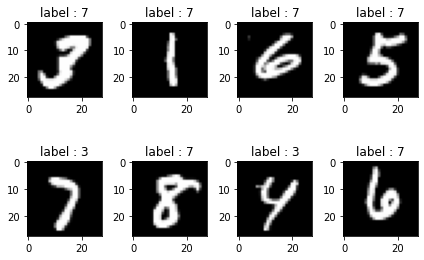

In [ ]:
my_classifier = CNN_classifier()  # assign classifier
if useGPU:
    my_classifier = my_classifier.to(device)


# show the performance of untrained classifier
print('current classification')
if useGPU:
    prediction = my_classifier(one_batch_data.to(device))  # passing forward function of classifier, return prediction
else:
     prediction = my_classifier(one_batch_data)  # passing forward function of classifier, return prediction
     
show_data(one_batch_data, thresholding(prediction))  # Initialize success, output is all zero!

## 4. Train Convolutional network classifier and monitor loss and accuracy for train, valid and test set

In [ ]:
#  numpy arrays to save loss & accuracy from each epoch
train_loss_iter = np.zeros(n_iter, dtype=float)  # Temporary numpy array to save loss for each epoch
valid_loss_iter = np.zeros(n_iter, dtype=float)
train_accuracy_iter = np.zeros(n_iter, dtype=float)  # Temporary numpy array to save accuracy for each epoch
valid_accuracy_iter = np.zeros(n_iter, dtype=float)

# We are going to use Binary cross entropy loss (built in Pytorch!)
criterion = torch.nn.CrossEntropyLoss()


# We can use either SGD or Adam (and there are other choices as well)
#optimizer = torch.optim.SGD(my_classifier.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(my_classifier.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


# main iteration
for iteration in range(n_iter):  

    # Training
    total_loss, total_cnt, correct_cnt = 0.0, 0.0, 0.0 # initialize a few variabels

    for batch_idx, (x, target) in enumerate(train_loader): # for each mini-batch
        if useGPU:
            x, target = x.cuda(), target.cuda()              

        prediction = my_classifier(x)  # Forward pass (of a mini-batch of training data)
        
        optimizer.zero_grad()  # Pytorch does not overwrite gradients, but it 'accumulates' them. Thus, we need to set gradient as 0 before we start.
        loss = criterion(prediction, target)   # Calculate cross-entropy loss 
        loss.backward()  # Pytorch automatically performs back-propagation to calculate gradients
        optimizer.step() # Using the optimizer and the calculated gradients, update parameters of classifier 

        total_loss += loss.item() # accumulate loss
        total_cnt += x.data.size(0) # accumulate the number of data
        correct_cnt += (thresholding(prediction) == target.data).sum().item() # accumulate the number of correct predictions
   
    accuracy = correct_cnt * 1.0 / total_cnt  # calculate accuracy  (#accumulated-correct-prediction/#accumulated-data)
    train_loss_iter[iteration] = total_loss / total_cnt # calculate and save loss (#accumulated-loss/#accumulated-data)
    train_accuracy_iter[iteration] = accuracy  # save accuracy
        

    # Validation
    total_loss, total_cnt, correct_cnt = 0.0, 0.0, 0.0 # initialize a few variabels
    for batch_idx, (x, target) in enumerate(valid_loader):  # for each mini-batch
        with torch.no_grad(): # we do not need to calculation gradient for validation data
            if useGPU:
                x, target = x.cuda(), target.cuda()
            
            prediction = my_classifier(x) # Forward pass (of a mini-batch of validation data)
            loss = criterion(prediction, target) # Calculate cross-entropy loss 

            total_loss += loss.item() # accumulate loss
            total_cnt += x.data.size(0) # accumulate the number of data
            correct_cnt += (thresholding(prediction) == target.data).sum().item()  # accumulate the number of correct predictions
    
    accuracy = correct_cnt * 1.0 / total_cnt  # calculate accuracy  (#accumulated-correct-prediction/#accumulated-data)
    valid_loss_iter[iteration]  = total_loss / total_cnt  # calculate and save loss (#accumulated-loss/#accumulated-data)
    valid_accuracy_iter[iteration] = accuracy # save accuracy

    # print message every 10 epochs
    if iteration % 10 == 0:
        print(f"[{iteration}/{n_iter}] Train Loss : {train_loss_iter[iteration]:.4f} Train Acc : {train_accuracy_iter[iteration]:.2f} \
        Valid Loss : {valid_loss_iter[iteration]:.4f} Valid Acc : {valid_accuracy_iter[iteration]:.2f}")

[0/50] Train Loss : 0.0019 Train Acc : 0.73         Valid Loss : 0.0006 Valid Acc : 0.90
[10/50] Train Loss : 0.0001 Train Acc : 0.98         Valid Loss : 0.0001 Valid Acc : 0.98
[20/50] Train Loss : 0.0001 Train Acc : 0.99         Valid Loss : 0.0001 Valid Acc : 0.99
[30/50] Train Loss : 0.0000 Train Acc : 0.99         Valid Loss : 0.0001 Valid Acc : 0.99
[40/50] Train Loss : 0.0000 Train Acc : 1.00         Valid Loss : 0.0001 Valid Acc : 0.99


## 5-1. Plot loss and accuracy of train, valid and test set for epoch

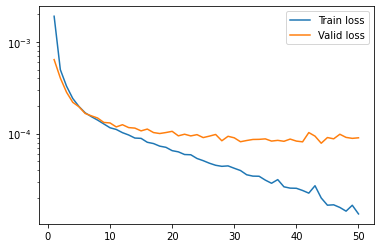

In [ ]:
# plot loss curve
l1, = plt.semilogy(range(1,n_iter+1), train_loss_iter)
l2, = plt.semilogy(range(1,n_iter+1), valid_loss_iter)
plt.legend([l1, l2], ["Train loss", "Valid loss"])

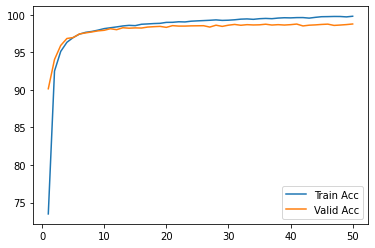

In [ ]:
# plot accuracy curve
l1, = plt.plot(range(1,n_iter+1), 100*train_accuracy_iter)
l2, = plt.plot(range(1,n_iter+1), 100*valid_accuracy_iter)

plt.legend([l1, l2], ["Train Acc", "Valid Acc"])

## 5-2. Visualize classification result of test set after training

After training


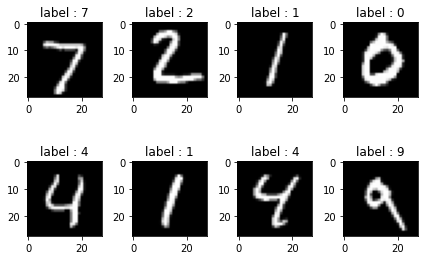

In [ ]:
# For test data
print('After training')
[one_batch_data, one_batch_label] = next(iter(test_loader))
if useGPU:
    prediction = my_classifier(one_batch_data.to(device))
else:
    prediction = my_classifier(one_batch_data)
show_data(one_batch_data, thresholding(prediction))